In [1]:
!pip install pyarrow

In [22]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [35]:
#helper functions

def preprocess_df(df, vectorizer=None):
    df['duration'] = df.dropOff_datetime - df.pickup_datetime
    df['duration'] = df.duration.apply(lambda x : x.total_seconds() / 60)
    df_filtered = df[(df.duration >= 1) & (df.duration <= 60)]
    df_filtered[['PUlocationID','DOlocationID']] = df_filtered[['PUlocationID','DOlocationID']].fillna(-1)
    if vectorizer is not None:
        dicts = df_filtered[['PUlocationID','DOlocationID']].to_dict(orient='records')
        X = dv.fit_transform(dicts)
        return df_filtered,X
    return df_filtered,_

Q1. Downloading the data

We'll use the same [NYC taxi dataset](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page), but instead of "Green Taxi Trip Records", we'll use "For-Hire Vehicle Trip Records".

Download the data for January and February 2021.

Note that you need "For-Hire Vehicle Trip Records", not "High Volume For-Hire Vehicle Trip Records".

Read the data for January. How many records are there?

In [3]:
data_jan = pd.read_parquet('data/fhv_tripdata_2021-01.parquet')

In [5]:
data_jan.shape

(1154112, 7)

Q2. Computing duration

Now let's compute the duration variable. It should contain the duration of a ride in minutes.

What's the average trip duration in January?

In [6]:
data_jan.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037


In [7]:
data_jan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1154112 entries, 0 to 1154111
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   dispatching_base_num    1154112 non-null  object        
 1   pickup_datetime         1154112 non-null  datetime64[ns]
 2   dropOff_datetime        1154112 non-null  datetime64[ns]
 3   PUlocationID            195845 non-null   float64       
 4   DOlocationID            991892 non-null   float64       
 5   SR_Flag                 0 non-null        object        
 6   Affiliated_base_number  1153227 non-null  object        
dtypes: datetime64[ns](2), float64(2), object(3)
memory usage: 61.6+ MB


In [4]:
data_jan['duration'] = data_jan.dropOff_datetime - data_jan.pickup_datetime
data_jan['duration'] = data_jan.duration.apply(lambda x : x.total_seconds() / 60)

In [5]:
print(f"Average trip duration in Jan: {np.round(np.mean(data_jan.duration),2)} minutes")

Average trip duration in Jan: 19.17 minutes


<b>Data preparation</b>

Check the distribution of the duration variable. There are some outliers.

Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

How many records did you drop?

In [9]:
data_jan.duration.describe()

count    1.154112e+06
mean     1.916722e+01
std      3.986922e+02
min      1.666667e-02
25%      7.766667e+00
50%      1.340000e+01
75%      2.228333e+01
max      4.233710e+05
Name: duration, dtype: float64

<AxesSubplot:xlabel='duration'>

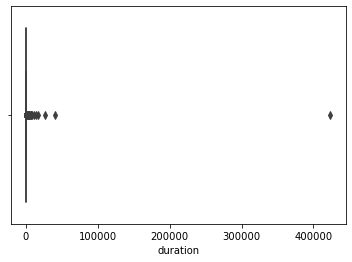

In [8]:
sns.boxplot(x=data_jan.duration)

In [6]:
data_jan_filtered = data_jan[(data_jan.duration >= 1) & (data_jan.duration <= 60)]

In [7]:
print(f"No. of dropped rows: {data_jan.shape[0] - data_jan_filtered.shape[0]}")

No. of dropped rows: 44286


Q3. Missing values

The features we'll use for our model are the pickup and dropoff location IDs.

But they have a lot of missing values there. Let's replace them with "-1".

What's the fractions of missing values for the pickup location ID? I.e. fraction of "-1"s after you filled the NAs.

In [11]:
print(f"Percentage of NAs of pickup location ID: {data_jan_filtered.PUlocationID.isna().sum()/data_jan_filtered.shape[0]}")
print(f"Percentage of NAs of dropoff location ID: {data_jan_filtered.DOlocationID.isna().sum()/data_jan_filtered.shape[0]}")

Percentage of NAs of pickup location ID: 0.8352732770722617
Percentage of NAs of dropoff location ID: 0.13327044059158824


In [14]:
data_jan_filtered[['PUlocationID','DOlocationID']] = data_jan_filtered[['PUlocationID','DOlocationID']].fillna(-1)                   

/tmp/ipykernel_132/1257331525.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_jan_filtered[['PUlocationID','DOlocationID']] = data_jan_filtered[['PUlocationID','DOlocationID']].fillna(-1)


Q4. One-hot encoding

Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

    Turn the dataframe into a list of dictionaries
    Fit a dictionary vectorizer
    Get a feature matrix from it

What's the dimensionality of this matrix? (The number of columns).

    2
    152
    352
    525
    725


In [23]:
dv = DictVectorizer()

train_dicts = data_jan_filtered[['PUlocationID','DOlocationID']].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts) 

In [24]:
X_train

<1109826x2 sparse matrix of type '<class 'numpy.float64'>'
	with 2219652 stored elements in Compressed Sparse Row format>

Q5. Training a model

Now let's use the feature matrix from the previous step to train a model.

    Train a plain linear regression model with default parameters
    Calculate the RMSE of the model on the training data

What's the RMSE on train?

    5.52
    10.52
    15.52
    20.52


In [26]:
target = 'duration'
y_train = data_jan_filtered[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

11.415432830521663

/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


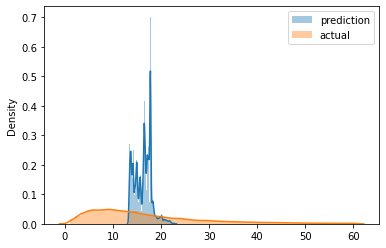

In [27]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

Q6. Evaluating the model

Now let's apply this model to the validation dataset (Feb 2021).

What's the RMSE on validation?

    6.01
    11.01
    16.01
    21.01


In [33]:
valid_data = pd.read_parquet('data/fhv_tripdata_2021-02.parquet')

In [34]:
valid_filtered,X_valid = preprocess_df(valid_data, dv)

/tmp/ipykernel_132/3425156353.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[['PUlocationID','DOlocationID']] = df_filtered[['PUlocationID','DOlocationID']].fillna(-1)


In [36]:
y_valid = valid_filtered[target].values

pred = lr.predict(X_valid)

mean_squared_error(y_valid, pred, squared=False)

11.85822362355935